<div class="alert alert-block alert-warning">
<b>Costs:</b> This QPU simulation costs $0 US dollars.
</div>

<div class="alert alert-block alert-success">
<b>This simulation finds ground state energy for H2 molecule. </b>
<div>Obs. 1: The data is saved in external files so that it can be worked on without incurring new costs.</div>
<div>Obs. 2: For new simulation parameters, save in a file with a different name.</div>
</div>

# Instructions if you are running outside AWS cloud

1. Install aws-cli:

`sudo apt install aws-cli`

2. Setup aws credentials:

`aws configure --profile "default"`

3. Create virtual environment 

`python -m venv /path/to/new/virtual/environment`

4. Activate virtual environment

`source /path/to/new/virtual/environment/bin/activate`

In [55]:
from boto3 import Session
from braket.aws import AwsSession

# Start Boto3 Session with your credentials profile
boto_session = Session(profile_name='default')

# Initialize Braket session with Boto3 Session credentials
aws_session = AwsSession(boto_session=boto_session)

# Defining the function to save results to json file and read results from file

In [56]:
import json

def save_to_file(data, file_name):
    with open(file_name+".json", "w") as file:
        json.dump(data, file, indent=4)

def read_from_file(file_name):
    with open(file_name+".json", 'r') as file:
        data = json.load(file)
    return data

# PES H2

In [72]:
# PES H2
import pennylane as qml
from pennylane import qchem

# Hartree-Fock state
hf = qml.qchem.hf_state(electrons=2, orbitals=4)

print(hf)

from pennylane import numpy as np

# atomic symbols defining the molecule
symbols = ['H', 'H']

# list to store energies
energies = []

# set up a loop to change bond length
r_range = np.arange(0.5, 5.0, 0.1)

# keeps track of points in the potential energy surface
pes_point = 0

######################
# Cache da simulacao #
######################
params_memory = []   # Cache da simulacao: os ângulos ótimos
geometries = []      # Cache da simulacao: distâncias r

[1 1 0 0]


### Cache da simulacao

In [74]:
from dataclasses import asdict, dataclass
import json
import csv

# --- container for each geometry point ---
@dataclass
class VQEResult:
    r_ang: float            # distance (Å)
    energy_ha: float        # optimized energy (Hartree)
    params: list            # optimized angles
    circuit_ascii: str      # visualization
    # (optional) store op spec if you want to rebuild circuit from scratch:
    ops: list | None = None # list of (name, wires) tuples

results: list[VQEResult] = []

pes_point = 0
params_old = None

### Otimizacao

In [75]:
for r in r_range:
    # Change only the z coordinate of one atom
    coordinates = np.array([0.0, 0.0, 0.0, 0.0, 0.0, r])

    # Obtain the qubit Hamiltonian
    H, qubits = qchem.molecular_hamiltonian(symbols, coordinates, method='pyscf')

    # define the device, optimizer and circuit
    dev = qml.device("default.qubit", wires=qubits)
    opt = qml.GradientDescentOptimizer(stepsize=0.4)

    @qml.qnode(dev, interface='autograd')
    def circuit(parameters):
        # Prepare the HF state: |1100>
        qml.BasisState(hf, wires=range(qubits))
        qml.DoubleExcitation(parameters[0], wires=[0, 1, 2, 3])
        qml.SingleExcitation(parameters[1], wires=[0, 2])
        qml.SingleExcitation(parameters[2], wires=[1, 3])
        return qml.expval(H)  # we are interested in minimizing this expectation value

    # initialize the gate parameters
    params = np.zeros(3, requires_grad=True)

    # initialize with converged parameters from previous point
    if pes_point > 0:
        params = params_old

    prev_energy = 0.0
    for n in range(50):
        # perform optimization step
        params, energy = opt.step_and_cost(circuit, params)

        if np.abs(energy - prev_energy) < 1e-6:
            break
        prev_energy = energy

    #===================== CACHE ======================
    # ----- collect circuit & op spec -----
    circ_ascii = qml.draw(circuit)(params)

    # ----- store result in memory -----
    res = VQEResult(
        r_ang=float(r),
        energy_ha=float(energy),
        params=[float(x) for x in np.array(params)],
        circuit_ascii=circ_ascii
    )
    results.append(res)

    # ----- print a concise line and the circuit -----
    print(f"r = {r:.2f} Å  |  E = {float(energy): .8f} Ha  |  params = {np.array(params)}")
    print(circ_ascii)
    print("-"*70)

    # prepare next point
    params_old = params
    pes_point += 1
    #===========================================
    # ... seu código do loop ...
    # depois de obter `energy` e ter `params` (np.array), acrescente:

    if 'results' not in globals():
        results = []   # cria a lista só na primeira iteração

    results.append({
        "r_ang": float(r),                    # distância em Å
        "energy_ha": float(energy),          # energia (Hartree) no simulador
        "params": [float(x) for x in params] # todos os ângulos do ansatz
    })


r = 0.50 Å  |  E = -0.41078840 Ha  |  params = [0.09328952 0.         0.        ]
0: ─╭|Ψ⟩─╭G²(0.09)─╭G(0.00)──────────┤ ╭<𝓗>
1: ─├|Ψ⟩─├G²(0.09)─│────────╭G(0.00)─┤ ├<𝓗>
2: ─├|Ψ⟩─├G²(0.09)─╰G(0.00)─│────────┤ ├<𝓗>
3: ─╰|Ψ⟩─╰G²(0.09)──────────╰G(0.00)─┤ ╰<𝓗>
----------------------------------------------------------------------
r = 0.60 Å  |  E = -0.67651066 Ha  |  params = [0.10202802 0.         0.        ]
0: ─╭|Ψ⟩─╭G²(0.10)─╭G(0.00)──────────┤ ╭<𝓗>
1: ─├|Ψ⟩─├G²(0.10)─│────────╭G(0.00)─┤ ├<𝓗>
2: ─├|Ψ⟩─├G²(0.10)─╰G(0.00)─│────────┤ ├<𝓗>
3: ─╰|Ψ⟩─╰G²(0.10)──────────╰G(0.00)─┤ ╰<𝓗>
----------------------------------------------------------------------
r = 0.70 Å  |  E = -0.84632591 Ha  |  params = [0.1123402 0.        0.       ]
0: ─╭|Ψ⟩─╭G²(0.11)─╭G(0.00)──────────┤ ╭<𝓗>
1: ─├|Ψ⟩─├G²(0.11)─│────────╭G(0.00)─┤ ├<𝓗>
2: ─├|Ψ⟩─├G²(0.11)─╰G(0.00)─│────────┤ ├<𝓗>
3: ─╰|Ψ⟩─╰G²(0.11)──────────╰G(0.00)─┤ ╰<𝓗>
----------------------------------------------------------------------
r = 0.80 Å  |  E

/var/folders/g1/_sv3n23d2yq5w04jzglv_r580000gn/T/ipykernel_3202/1450625176.py:91: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


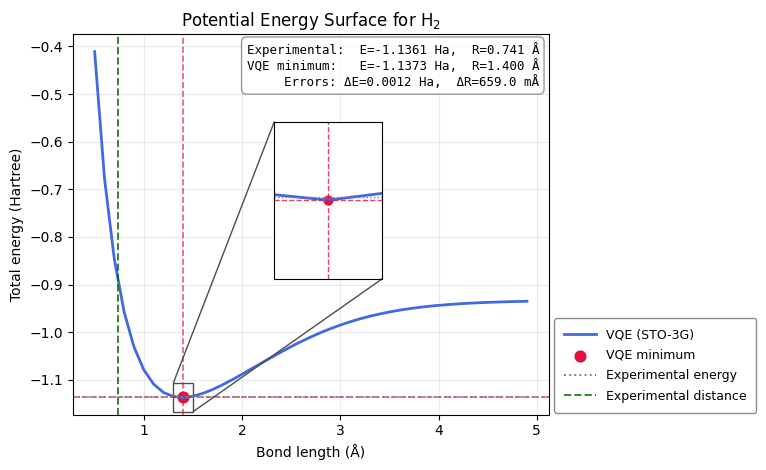

Equilibrium bond length: 1.400 Å
Minimum energy: -1.137275 Hartree
Dissociation energy ΔE: 0.202031 Hartree
Errors relative to experiment: ΔE = 0.00118 Eh, ΔR = 659.0 mÅ


In [77]:
# ================== PLOT A PARTIR DE `results` ==================
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset

# 1) Extrai dados de forma robusta
def _get(item, key):
    # funciona para dicts e para objetos com atributos
    if isinstance(item, dict):
        return item[key]
    return getattr(item, key)

assert len(results) > 0, "A lista `results` está vazia — rode o loop VQE antes."

r_list   = np.array([_get(x, "r_ang")     for x in results], dtype=float)
E_list   = np.array([_get(x, "energy_ha") for x in results], dtype=float)

# 2) Escolha a unidade de entrada (ajuste conforme seu loop!)
R_IN_BOHR = False  # coloque True se seu `r_ang` estiver em Bohr
bohr_to_ang = 0.529177210903
r_ang = r_list * (bohr_to_ang if R_IN_BOHR else 1.0)
energies_np = E_list.copy()

# 3) Referência experimental (H2)
E_exp    = -1.1361      # Hartree
R_exp_ang = 0.741       # Å

# 4) Ponto mínimo (do VQE)
idx_min = int(np.argmin(energies_np))
e_eq    = float(energies_np[idx_min])
r_eq    = float(r_ang[idx_min])

# 5) Erros
err_E = abs(e_eq - E_exp)
err_R = abs(r_eq - R_exp_ang)

# 6) Plot
fig, ax = plt.subplots(figsize=(7.5, 4.8))
ax.plot(r_ang, energies_np, lw=2, color="royalblue", label="VQE (STO-3G)")

# marcadores e linhas do mínimo
ax.scatter(r_eq, e_eq, color="crimson", s=60, label="VQE minimum")
ax.axvline(r_eq, ls="--", lw=1.2, color="crimson", alpha=0.7)
ax.axhline(e_eq, ls="--", lw=1.2, color="crimson", alpha=0.7)

# referências experimentais
ax.axhline(E_exp, color="gray", ls=":", lw=1.4, label="Experimental energy")
ax.axvline(R_exp_ang, color="darkgreen", ls="--", lw=1.4, alpha=0.8,
           label="Experimental distance")

# caixa de texto
legend_text = (
    f"Experimental:  E={E_exp:+.4f} Ha,  R={R_exp_ang:.3f} Å\n"
    f"VQE minimum:   E={e_eq:+.4f} Ha,  R={r_eq:.3f} Å\n"
    f"Errors: ΔE={err_E:.4f} Ha,  ΔR={err_R*1000:.1f} mÅ"
)
ax.text(
    0.98, 0.98, legend_text,
    transform=ax.transAxes, fontsize=9, family="monospace",
    va="top", ha="right",
    bbox=dict(boxstyle="round,pad=0.4", facecolor="white", alpha=0.8, edgecolor="gray")
)

# inset de zoom no mínimo
dx, dy = 0.10, 0.03  # janela de zoom
axins = zoomed_inset_axes(ax, zoom=5.5, loc="upper left",
                          bbox_to_anchor=(0.40, 0.80),
                          bbox_transform=ax.transAxes, borderpad=0.8)
axins.plot(r_ang, energies_np, lw=2, color="royalblue")
axins.scatter(r_eq, e_eq, color="crimson", s=40)
axins.axvline(r_eq, ls="--", lw=1.0, color="crimson", alpha=0.8)
axins.axhline(e_eq, ls="--", lw=1.0, color="crimson", alpha=0.8)
axins.axhline(E_exp, color="gray", ls=":", lw=1.0)
axins.axvline(R_exp_ang, color="darkgreen", ls="--", lw=1.0, alpha=0.8)
axins.set_xlim(r_eq - dx, r_eq + dx)
axins.set_ylim(e_eq - dy, e_eq + dy)
axins.tick_params(labelleft=False, labelbottom=False, length=0)
mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.3", lw=1.0)

# estética
ax.set_xlabel("Bond length (Å)")
ax.set_ylabel("Total energy (Hartree)")
ax.set_title("Potential Energy Surface for H$_2$")
legend = ax.legend(
    frameon=True, fontsize=9, loc="upper right", bbox_to_anchor=(1.45, 0.27),
    labelspacing=0.6, handlelength=2.5, handletextpad=0.8, borderpad=0.8,
    facecolor="white", edgecolor="gray", framealpha=0.9
)
ax.grid(alpha=0.25)
ax.set_box_aspect(0.8)
plt.tight_layout()
plt.show()

# 7) Resumo no terminal
print(f"Equilibrium bond length: {r_eq:.3f} Å")
print(f"Minimum energy: {e_eq:.6f} Hartree")
print(f"Dissociation energy ΔE: {energies_np[-1] - e_eq:.6f} Hartree")
print(f"Errors relative to experiment: ΔE = {err_E:.5f} Eh, ΔR = {err_R*1000:.1f} mÅ")

/var/folders/g1/_sv3n23d2yq5w04jzglv_r580000gn/T/ipykernel_87226/3586986310.py:120: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


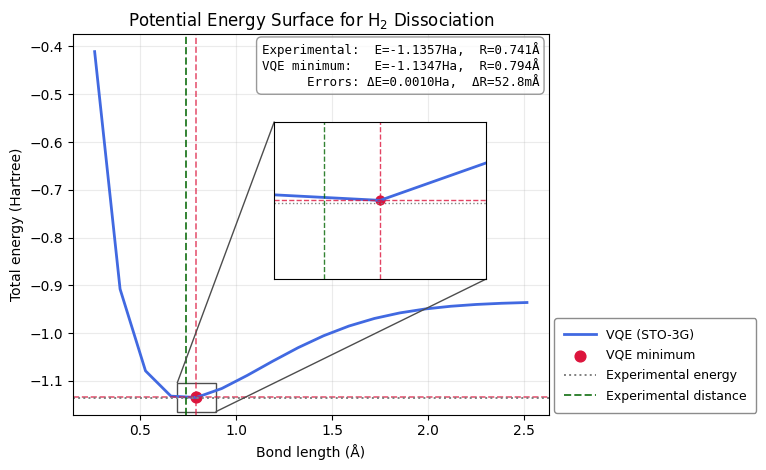

Equilibrium bond length: 0.794 Å
Minimum energy: -1.134690 Hartree
Dissociation energy ΔE: 0.198772 Hartree
Errors relative to experiment: ΔE = 0.00101 Eh, ΔR = 52.8 mÅ


In [27]:
import numpy as np
import matplotlib.pyplot as plt

# =======================================
# Dados e constantes
# =======================================
bohr_to_ang = 0.529177210903
energies_np = np.asarray(energies, dtype=float)
r_np_bohr = np.asarray(r_range, dtype=float)
r_np_ang = r_np_bohr * bohr_to_ang  # conversão para angstrons

# Referência experimental
E_exp = -1.1357  # Hartree
R_exp_ang = 0.741  # Å

# Mínimo do VQE
e_eq = float(np.min(energies_np))
idx = int(np.argmin(energies_np))
bond_length_ang = float(r_np_ang[idx])

# Erros relativos
err_E = abs(e_eq - E_exp)
err_R = abs(bond_length_ang - R_exp_ang)

# =======================================
# Plot
# =======================================
fig, ax = plt.subplots(figsize=(7.5, 4.8))
ax.plot(r_np_ang, energies_np, lw=2, color="royalblue", label="VQE (STO-3G)")

# Linhas e marcadores principais
ax.scatter(bond_length_ang, e_eq, color="crimson", s=60, label="VQE minimum")
ax.axvline(bond_length_ang, ls="--", lw=1.2, color="crimson", alpha=0.7)
ax.axhline(e_eq, ls="--", lw=1.2, color="crimson", alpha=0.7)

# Linha experimental
ax.axhline(E_exp, color="gray", ls=":", lw=1.4, label="Experimental energy")
ax.axvline(R_exp_ang, color="darkgreen", ls="--", lw=1.4, alpha=0.8,
           label="Experimental distance")

# =======================================
# Caixa de texto com resultados e erros
# =======================================
legend_text = (
    f"Experimental:  E={E_exp:+.4f}Ha,  R={R_exp_ang:.3f}Å\n"
    f"VQE minimum:   E={e_eq:+.4f}Ha,  R={bond_length_ang:.3f}Å\n"
    f"Errors: ΔE={err_E:.4f}Ha,  ΔR={err_R*1000:.1f}mÅ"
)

ax.text(
    0.98, 0.98, legend_text,
    transform=ax.transAxes,
    fontsize=9,
    family="monospace",
    va="top",
    ha="right",
    bbox=dict(boxstyle="round,pad=0.4", facecolor="white", alpha=0.8, edgecolor="gray")
)

from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset

# =======================================
# Inset de ZOOM no ponto mínimo
# =======================================
# Tamanho da janela de zoom (ajuste se precisar)
dx = 0.10  # Å para cada lado do mínimo
dy = 0.03  # Ha para cima/baixo do mínimo

# cria um eixo "inset" com nível de zoom
axins = zoomed_inset_axes(ax, zoom=5.5, loc="upper left",
                          bbox_to_anchor=(0.4, 0.8),  # posição dentro do gráfico (x,y)
                          bbox_transform=ax.transAxes, borderpad=0.8)

# repete no inset tudo que importa: curva, linhas e marcador
axins.plot(r_np_ang, energies_np, lw=2, color="royalblue")
axins.scatter(bond_length_ang, e_eq, color="crimson", s=40)



axins.axvline(bond_length_ang, ls="--", lw=1.0, color="crimson", alpha=0.8)
axins.axhline(e_eq, ls="--", lw=1.0, color="crimson", alpha=0.8)
axins.axhline(E_exp, color="gray", ls=":", lw=1.0)
axins.axvline(R_exp_ang, color="darkgreen", ls="--", lw=1.0, alpha=0.8)

# limites da área ampliada
axins.set_xlim(bond_length_ang - dx, bond_length_ang + dx)
axins.set_ylim(e_eq - dy, e_eq + dy)

# tira ticks pra ficar limpo (opcional)
axins.tick_params(labelleft=False, labelbottom=False, length=0)

# desenha “retângulo de ligação” entre a área ampliada e o inset
mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.3", lw=1.0)


# =======================================
# Layout e estética
# =======================================
ax.set_xlabel("Bond length (Å)")
ax.set_ylabel("Total energy (Hartree)")
ax.set_title("Potential Energy Surface for H$_2$ Dissociation")
# =======================================
# Legenda refinada
# =======================================
legend = ax.legend(
    frameon=True,
    fontsize=9,
    loc="upper right",
    bbox_to_anchor=(1.45, 0.27),  # desloca para centro vertical
    labelspacing=0.6,
    handlelength=2.5,
    handletextpad=0.8,
    borderpad=0.8,
    facecolor="white",
    edgecolor="gray",
    framealpha=0.9
)
ax.grid(alpha=0.25)
ax.set_box_aspect(0.8)
plt.tight_layout()
plt.show()

# =======================================
# Resumo numérico no terminal
# =======================================
print(f"Equilibrium bond length: {bond_length_ang:.3f} Å")
print(f"Minimum energy: {e_eq:.6f} Hartree")
print(f"Dissociation energy ΔE: {energies_np[-1] - e_eq:.6f} Hartree")
print(f"Errors relative to experiment: ΔE = {err_E:.5f} Eh, ΔR = {err_R*1000:.1f} mÅ")

### Imprime os parâmetros ótimos

In [48]:
print("\n=== TABELA DE RESULTADOS ===")
print(f"{'R (Å)':>8} | {'Energia (Ha)':>14} | {'Ângulo θ (rad)':>14}")
print("-"*45)

for r, E, res in zip(r_range, energies, results):
    # tenta pegar o primeiro parâmetro
    try:
        theta = float(res.params[0])
    except Exception:
        theta = np.nan
    print(f"{r:8.3f} | {E:14.8f} | {theta:14.6f}")

print("-"*45)


=== TABELA DE RESULTADOS ===
   R (Å) |   Energia (Ha) | Ângulo θ (rad)
---------------------------------------------
   0.500 |    -0.41078840 |       0.093290
   0.750 |    -0.90772282 |       0.117975
   1.000 |    -1.07896962 |       0.151794
   1.250 |    -1.13191293 |       0.194600
   1.500 |    -1.13468979 |       0.247235
   1.750 |    -1.11589935 |       0.310672
   2.000 |    -1.08849510 |       0.385631
   2.250 |    -1.05881814 |       0.473498
   2.500 |    -1.03047197 |       0.574331
   2.750 |    -1.00558029 |       0.684537
   3.000 |    -0.98515403 |       0.799838
   3.250 |    -0.96933326 |       0.913927
   3.500 |    -0.95767240 |       1.021756
   3.750 |    -0.94942310 |       1.118287
   4.000 |    -0.94377505 |       1.202372
   4.250 |    -0.94000141 |       1.273698
   4.500 |    -0.93752332 |       1.332547
   4.750 |    -0.93591752 |       1.381286
---------------------------------------------


### Salva em .csv

In [54]:
import csv

# Cria arquivo CSV simples
with open("pes_vqe_resultados.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["R (Å)", "Energia (Ha)", "Ângulo θ (rad)"])  # cabeçalhos
    
    for r, E, res in zip(r_range, energies, results):
        try:
            theta = float(res.params[0])
        except Exception:
            theta = np.nan
        writer.writerow([r, E, theta])

print("✅ Arquivo 'pes_vqe_resultados.csv' salvo com sucesso!")

✅ Arquivo 'pes_vqe_resultados.csv' salvo com sucesso!
